In [1]:
#%nbtoc
from clifford import * 
pretty(precision=2)

layout, blades = Cl(3,1, firstIdx=1)

# assign vector basis
e1,e2,e3,e4 = [blades['e%i'%k] for k in range(1,5)]

# setup  null basis, and minkowski subspace bivector
eo = .5^(e4-e3)
einf= e3+e4
E0= einf^eo
I = e1^e2^e3^e4




rb = lambda g:randomMV(layout, grades=[g])
v4 =  lambda : rb(1)

def v2():
    x=v4()
    return x- E0.project(x)


# CGA up/down projections
up = lambda x: x + (.5^((x**2)*einf)) + eo
homo = lambda x: x * (-x|einf).normalInv() # homogenise conformal vector
down = lambda x: (homo(x)^E0)*E0


# complex <-> vector 
c2v = lambda x: (x.real*e1) + (x.imag*e2) # complex2vector
v2c = lambda x: float(x|e1)+ float(x|e2)*1j

cot = lambda x: 1./tan(x)

Rot = lambda V,X: V*X*V.inv()
t = lambda A: 1-(.25*(einf*A)*(einf|A).inv()*(1+E0))
T =lambda a: 1+(.5^(einf*a))



A = v4()
a = down(A)
assert (T(a)==t(up(a)))

In [2]:
def equivalent(f_c, F,  args=[], debug=False):
    tol = 1e-6
    x_c = rand()+ rand()*1j
    x = c2v(x_c) 
    X = up(x)
    vargs = args[:]
    for k in range(len(vargs)):
        if imag(vargs[k])!= 0:
            vargs[k] = c2v(vargs[k])
    Y = F(X, *vargs)
    y = down(Y)
    y_c = v2c(y)
    if debug:
        print  (y_c, f_c(x_c,*args))
        return abs(y_c - f_c(x_c,*args)) < tol
    return abs(y_c - f_c(x_c,*args)) < tol


## conformal operations
CI = lambda X: Rot((e2^e3),X) # complex inversion
Add = lambda X,Y: Rot(t(Y),X)
#Mul = lambda X,Y: 


## basis transforms
Rzy = e**(pi/2*(e2^e3))
Ryz = ~Rzy
Rsz = e**(pi/4*(e1^e3))
Rzs = ~Rsz
Rsy = e**(-pi/(sqrt(2)*2)*(e2*e3+e2*e1))
Rys = ~Rsy

##################################################
##  Complex Conjugation ( Z<->Z~)
f_c = lambda x: x.conjugate()
F = lambda X:  e2*X*e2
assert equivalent(f_c,F)

##  Complex Inversion ( Z<->Y)
f_c = lambda x: 1./x
F = lambda X:  Rot(Ryz,X)
assert equivalent(f_c,F)


##  Basis Transform ( Z<->S)
f_c = lambda x: (x-1)/(x+1)
F = lambda X:  Rot(Rsz,X)
assert equivalent(f_c,F)


##  Basis Transform  ( Y<->S)
f_c = lambda x: (1-x)/(1+x)
F = lambda X:  Rot(Rsy,X)
assert equivalent(f_c,F)

In [3]:
## Transsmission lines
Ls = lambda theta: e**(theta *(e1^e2))
Lz = lambda theta: e**(-theta *(e2^e3))

## Transmission line  (S)
f_c = lambda x,theta: x*e**(-2j*theta)
F = lambda X,theta:  Rot(Ls(theta),X)
theta = rand()
assert equivalent(f_c,F, args =[theta])

## Transmission line  (Z)
f_c = lambda x,theta: (x+1j*tan(theta))/(1+x*1j*tan(theta))
F = lambda X,theta:  Rot(Lz(theta),X)
theta = rand()
assert equivalent(f_c,F, args =[theta])


In [4]:

## Distributed Element Group

# bivector algebra 
R =  e3*e4-e1*e3
X = -e2*e4+e1*e2
G =  e3*e4+e1*e3
B =  e2*e4+e1*e2
N =  e1*e4
Q =  e3*e2

half=.5
# Rotors
Rr = lambda x: e**(half*x*R)
Rx = lambda x:e**(half*x*X)
Rg = lambda x:e**(half*x*G)
Rb = lambda x:e**(half*x*B)
Rn = lambda x:e**(half*log(x)*N)
Rq = lambda x:e**(half*x*Q)

## Resistance
f_c = lambda x,z: ((1+x)/(1-x)+z-1)/((1+x)/(1-x)+z+1)
F = lambda A,a:  Rot(Rr(a),A)
z = rand()
assert equivalent(f_c,F, args =[z])

## Reactance
f_c = lambda x,z: ((1+x)/(1-x)+z*1j-1)/((1+x)/(1-x)+z*1j+1)
F = lambda A,a:  Rot(Rx(a),A)
z = rand()
assert equivalent(f_c,F, args =[z])

## Conductance
f_c = lambda x,z: (1-((1-x)/(1+x)+z))/(1+(1-x)/(1+x)+z)
F = lambda X,x:  Rot(Rg(x),X)
z = rand()
assert equivalent(f_c,F, args=[z])


## Susceptance
f_c = lambda x,z: (1-((1-x)/(1+x)+1j*z))/(1+(1-x)/(1+x)+1j*z)
F = lambda X,x:  Rot(Rb(x),X)
z = rand()
assert equivalent(f_c,F, args=[z])

In [5]:
#stubs
cot = lambda x: 1./tan(x)
Rss = lambda theta: e**(-cot(theta)/2*B)

## Shunt short
f_c = lambda x,theta: (1-((1-x)/(1+x)-1j*cot(theta)))/(1+((1-x)/(1+x)-1j*cot(theta)))
F = lambda X,theta:  Rot(Rss(theta),X)
theta = rand()
assert equivalent(f_c,F, args=[theta],debug=1)

((-0.07697088520951666+0.6824508196725123j), (-0.07697088520951657+0.6824508196725124j))


In [6]:
## down-projected formula 
theta, phi = rand(2)
g = e**(-2j*theta)*(1j*cot(phi))/(2-1j*cot(phi)) # series then shunt stub
assert(abs(g)- (sqrt(1/(4*tan(phi)**2+1)))<1e-6)
assert(tan(angle(g)) - (tan(2*theta)+2*tan(phi))/(2*tan(2*theta)*tan(phi)-1)<1e-6)

In [9]:
eps(1e-6)
pretty(9)



(-1.5, 1.5, -1.5, 1.5)

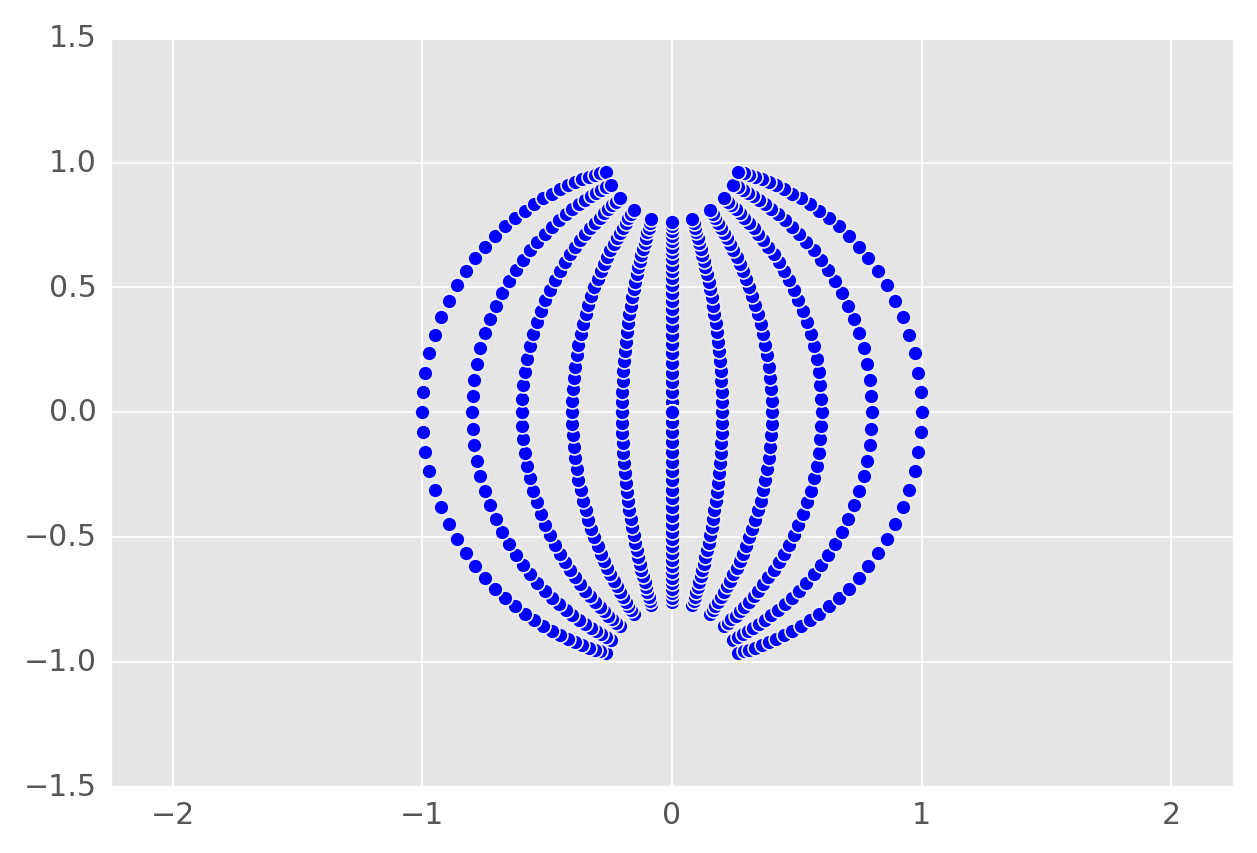

In [10]:
for y in linspace(-1,1,11):
    A = up(y*e1)
    for x in linspace(-1,1,51):
        R = e**(-x*e2^e4)
        a =down(R*A*~R)
        scatter(a|e1,a|e2)

axis('equal')

## Distributed Circuit 

In [11]:
# bivector algebra 
R =  e3*e4-e1*e3
X = -e2*e4+e1*e2
G =  e3*e4+e1*e3
B =  e2*e4+e1*e2
N =  e1*e4
Q =  e3*e2
L = e1*e2


half=.5

# Rotors
Rl = lambda x: e**(half*x*L)
Rr = lambda x: e**(half*x*R)
Rx = lambda x:e**(half*x*X)
Rg = lambda x:e**(half*x*G)
Rb = lambda x:e**(half*x*B)
Rn = lambda x:e**(half*log(x)*N)
Rq = lambda x:e**(half*x*Q)

### Various b/x fixed load 

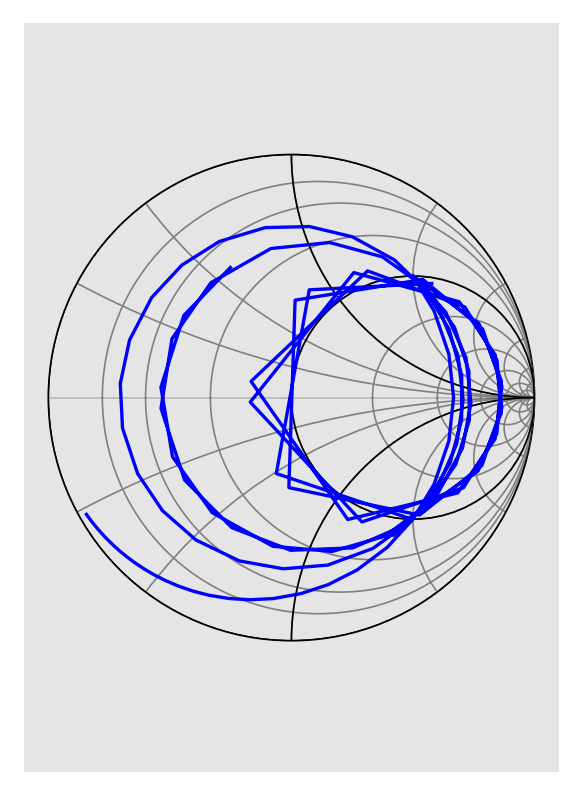

In [13]:
delta = 10e-3
Rxb = Rx(4*delta)*Rb(delta)
f= lambda x:Rx(x*delta)*Rb(delta)
gg = [.01,1,2,10]#linspace(.1,20,5)
nn =  linspace(0,400,31).round()

v=[ down((f(g)**n)*up(.5*e1+.5*e2)*(~(f(g)**n)))   for n in nn for g in gg]


#v.reshape([len(nn),len(gg)])

def plot_v(v):
    x=[float(k|e1) for k in v]
    y=[float(k|e2) for k in v]

    xx= array(x).reshape([len(nn),len(gg)])
    yy= array(y).reshape([len(nn),len(gg)])
    plot(xx,yy,   color = 'b')
    axis('equal')

plot_v(v)
rf.smith()

###  various loads fixed b/x

In [14]:
D = X*x+B*b
D**2


NameError: name 'b' is not defined

In [15]:
down(e1+e4)

(1.0^e1)

In [388]:
aI.inv()


-(1.0^e1234)

In [376]:
x=rand()
sinh(log(1/x)) , sinh(log(x))

(0.96703083046685823, -0.96703083046685823)

[[<matplotlib.lines.Line2D at 0x7faa30399750>],

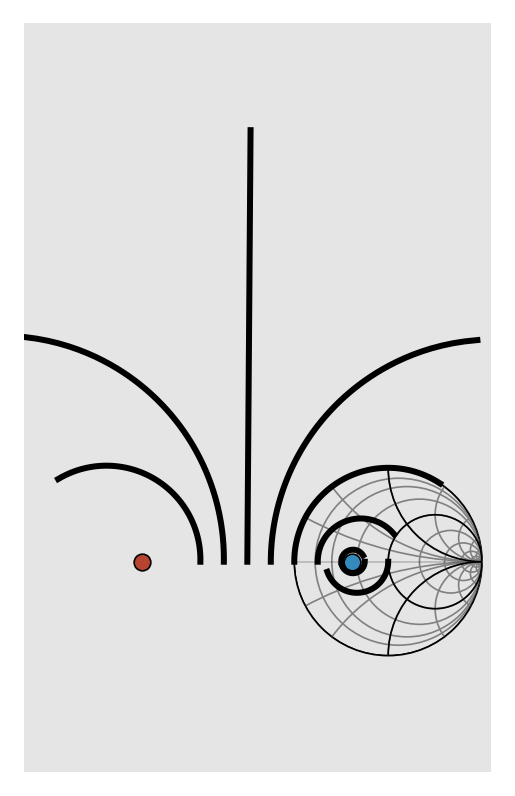

In [17]:
delta = 6e-3
x= 1.
b=5
Rxb = Rx(x*delta)*Rb(b*delta)#*Rr(1 *delta)*Rg(1*delta)
f = lambda n: Rx(n*x*delta)*Rb(n*b*delta)
f = lambda n: Rxb**n


gg = linspace(-2,0,9)
nn =  linspace(0,100,101).round()

#v=[down( (Rxb**n)*up(e**(2*g*pi*e12)*e1)*~(Rxb**n) )   for n in nn for g in gg]
v=[down( f(n)*up(g*e1)*~f(n) )   for n in nn for g in gg]


#v.reshape([len(nn),len(gg)])

def plot_v(v):
    x=[float(k|e1) for k in v]
    y=[float(k|e2) for k in v]

    xx= array(x).reshape([len(nn),len(gg)])
    yy= array(y).reshape([len(nn),len(gg)])
    plot(xx,yy,   color = 'k',lw=1.8)
    axis('equal')

plot_v(v)
rf.smith()

#z = array([exp(1j*x) for x in linspace(0,2*pi,201)])
#plot(z.real,z.imag,color='k',lw=1.8)
##ax= gca()
#ax.set_axis_bgcolor('white')
#ax.axes.get_yaxis().set_visible(False)
#ax.axes.get_xaxis().set_visible(False)
#axis([1,-1,1.1,-1.1])

z0=sqrt(x/b)
c1= (z0-1)/(z0+1)
c2= (z0+1)/(z0-1)
[plot(real(c),imag(c), marker = 'o',markersize=5) for c in [c1,c2]]

In [22]:
x=3
log(1./x) == -log(x)

True

In [438]:

c

inf

In [405]:
z0

2.5066282746310002

In [357]:
B**2

0

In [421]:
V = Rxb**40
D = V(2)/abs(V(2))
a = layout.randomV()

D=D.dual()

D = D/abs(D)
a_= a-(a^D)*D.inv()
ap=(a_+a_*D)
am=(a_-a_*D)

In [422]:
down(am), down(ap)

((0.171573625^e1) + (0.002058883^e2), (5.8275625^e1) + (0.06993075^e2))

In [156]:
B*I==I*B

True

In [146]:
xpb = -float(Rxb|e12)
xmb = -float(Rxb|e24)


In [148]:
e**(arctanh(xmb/xpb))

2.0000000000000004

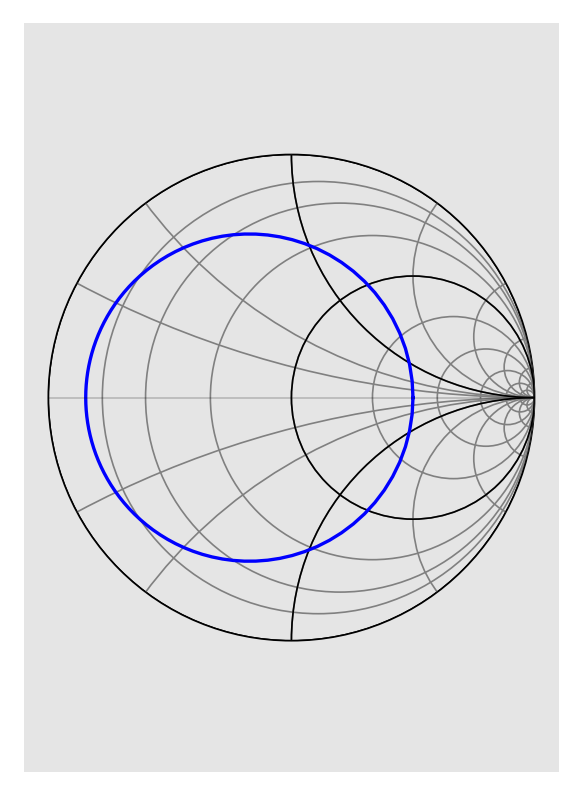

In [54]:
def plot_v(v):
    x=[float(k|e1) for k in v]
    y=[float(k|e2) for k in v]

    plot(x,y,   color = 'b')
    axis('equal')


e12 = e1^e2
e24  = e2^e4
y = 2

Rln = lambda x:  Rn(y)*Rl(x)*~Rn(y)
v=[down(Rln(x)*up(.5*e1)*~Rln(x)) for x in linspace(0,2*pi,101)]
plot_v(v)
rf.smith()

In [13]:
e**(log(4)*1j)


(0.18345697474330172+0.98302774041124374j)

In [17]:
log(10)/log(5)

1.4306765580733933

[None, None, None, None, None, None, None, None, None, None, None]

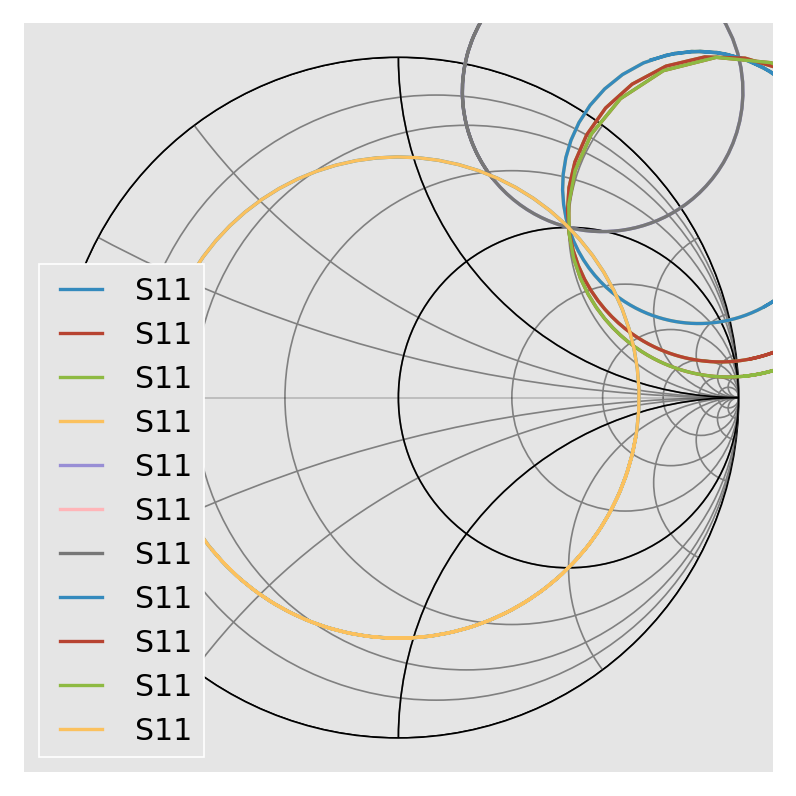

In [71]:
from skrf import air50
[(air50.line(150,'deg',z0=str(k),embed=1)**air50.load(.5+.5j)).plot_s_smith() for k in linspace(-1,1,11)]

In [19]:
air50.line

In [111]:
a = rand()*e1 + rand()*e2
A = up(a)

C = (A^(e2*A*e2)^up(0))
c = C.dual()

In [112]:
Cunit = up(e1)^up(e2)^up(-e1)
cunit = Cunit.dual()

In [113]:
c,cunit

(-(1.198422789^e1) + (0.577292854^e3) - (0.577292854^e4), (2.0^e3))

In [114]:
V=c/cunit


In [116]:
V*A*~V

(0.126763009^e1) + (0.339594151^e2) - (0.003443854^e3) + (0.362498149^e4)

In [118]:
V.dual()

-(0.288646427^e12) + (0.599211394^e24) - (0.288646427^e1234)